In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from nltk.classify.scikitlearn import SklearnClassifier
import math
import random

We declare a function, clean_comment, to regex and tokenize comments.

In [2]:
stop_words = set(stopwords.words("english"))

def clean_comment(comment):
    ps = PorterStemmer()
    regex = re.compile('[^ a-zA-Z]')
    cleaned_comment = regex.sub('', comment)
    tokenized_words = word_tokenize(cleaned_comment.lower())
    cleaned_comments = []

    for word in tokenized_words:
        if word not in stop_words:
            cleaned_comments.append(ps.stem(word))

    return cleaned_comments

We start by creating a df of our sample data.

In [3]:
df = pd.read_csv('stock_data.csv', sep=',', encoding='latin-1')

Let us look into class balance in the above df.

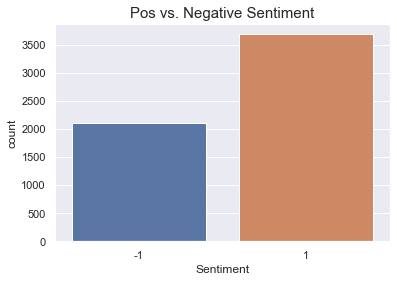

In [4]:
plt.figure(figsize = None)
sns.set_theme(style="darkgrid")
sns.countplot(x="Sentiment", data=df)
plt.title("Pos vs. Negative Sentiment", fontsize = 15)
plt.show()

Based on the above, we need to upsample our negative sentiment.

In [5]:
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == -1]

minority_upsample = resample(df_minority, replace = True, n_samples = df_majority.shape[0], random_state=101)

df_upsampled = pd.concat([minority_upsample, df_majority])
df_upsampled = df_upsampled.sample(frac=1)

Check our upsample

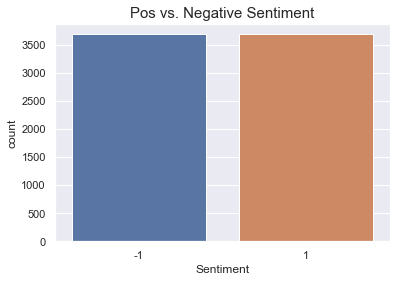

In [6]:
plt.figure(figsize = None)
sns.set_theme(style="darkgrid")
sns.countplot(x="Sentiment", data=df_upsampled)
plt.title("Pos vs. Negative Sentiment", fontsize = 15)
plt.show()

In [7]:
print(df_upsampled)

                                                   Text  Sentiment
5175  Global stocks waver, while oil markets are buo...          1
933   GEVO Broke out of a bull flag pattern to the u...          1
5047  Heard on the Street: Luxury, liquor and sungla...         -1
2238  ZNGA BYD MGM These ready to sell yet on the NJ...         -1
669   well done to those short aapl friday.....gutsy...          1
...                                                 ...        ...
474   HA EPS estimates being slashed as squeezed sto...         -1
630   GTAT healthy pullback on low volume after a ni...          1
1654  yhoo Blackrock increases position SC 13 G file...          1
1261                                  AMZN short 275.13         -1
2880  ed Daily Triangle on DEPO,....Open ong and Sho...         -1

[7370 rows x 2 columns]


 We begin by compiling a feature list of words from our positive and negative comments to begin to see trends in which words fall into which category generally.

We begin by building a frequency distribution of words in our comments. We can also use this to build our vocab.

In [8]:
# TASK CELL
def word_counter(comments, sentiment):
    '''
    Params:
        comments: a list of comments
        sentiment: a list corresponding to the sentiment of each message (either 0 or 1)
    Return:
        output_occurence: a dictionary mapping each pair to its frequency
    '''

    output_occurence = {}
    vocab = []


    for label, comment in zip(sentiment, comments):
        for word in clean_comment(comment):
            vocab.append(word)
            composite_key = (word, label)
            keys = output_occurence.keys()
            if composite_key in keys:
                output_occurence[composite_key] += 1
            else:
                output_occurence[composite_key] = 1

    vocab = set(vocab)
    
    return output_occurence, vocab

In [12]:
#random.shuffle(documents)
#print(documents[0])
vocab = []
comments = []
sentiments = []
documents = []



for comment in df_upsampled['Text']:
    comments.append(clean_comment(comment))

for sentiment in df_upsampled['Sentiment']:
    sentiments.append(sentiment)

for i in range(len(comments)):
    documents.append((comments[i], sentiments[i]))

random.shuffle(documents)

for comment in comments:
    for word in comment:
        vocab.append(word)

vocab = nltk.FreqDist(vocab)

vocab_features = list(vocab.keys())[:100]

print(documents[0][0])


['aap', 'clear', 'bullish', 'stock']


Now, we categorize each word as positive or negative. We build a function that finds words in our comments and gets their most frequent classification from the dictionary created in find_occurence.

In [13]:
def find_features(comment):
    '''
    Params:
        document: our comment and sentiment
    Return:
        the features, a dictionary of words in the comment mapped to sentiment
    '''
    words = comment
    features = {}

    for w in vocab_features:
        features[w] = (w in words)

    return features
    
        



In [15]:
featuresets = [(find_features(comment), sentiment) for (comment, sentiment) in documents]

print(featuresets[1])

IndexError: list index out of range

Let us see how this works on our training data.